# An inverted pendulum on a cart
&copy; 2023 @RR_Inyo<br/>
Released under the MIT license<br/>
https://opensource.org/licenses/mit-license.php<br/>

This version of notebook make use of scipy.integrate.solve_ivp instead of odeint.

Fig. 1 shows an inverted pendulum on a cart.
<figure><img src="inverted-pendulum-on-cart-with-disturbance.png"><figcaption>Fig. 1 Inverted pendulum on a cart</figcaption></figure><br/>
The motion equation of the system has been derived as follows.
$$
\begin{align}
(M + m) \ddot{x}_{c} + m l \ddot{\theta} \cos \theta &= -\mu_{c} \dot{x}_{c} + m l \dot{\theta}^{2} \sin \theta + f \tag{1} \\[10pt]
m l \ddot{x}_{c} \cos \theta + (J + m l^{2}) \ddot{\theta} &= -\mu_{p} \dot{\theta} + m g l \sin \theta + \underbrace{f_{d} \cos \theta}_{\mathrm{Disturbance}} \tag{2}
\end{align}
$$

In this form, it cannot be used as an input differential equation system for `scipy.integrate.solve_ivp` function. If we choose
$$\boldsymbol{x} = [x_c, \dot{x}_c, \theta, \dot{\theta}]^T$$
as the state variable, (1) and (2) shall be reorganized to obtain $\ddot{x}_{c}$ and $\ddot{\theta}$, which has been derived by SymPy in another notebook. The resultant equations are too complicated to print here. Nontheless, the function `func` below uses the results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
from scipy.constants import g
from IPython.display import HTML

In [2]:
# Parameters
M = 1.00                  # Mass of cart
m = 0.75                  # Mass of pendulum, kg
l = 0.30                  # Half length, m
J = m * l**2 / 3          # Inertia around center of mass, kg m**2
mu_c = 0.050              # Friction of cart, N/(m/s)
mu_p = 0.050              # Friction of pendulum, Nm/(rad/s)

In [3]:
# State feedback gain
F = np.array([20, 30, 150, 30])
# F = np.array([0, 0, 5, 120])
x_ofs = np.array([0, 0, 0, 0])
f_max = 20

In [4]:
# Force controller
# State x = [x_c, x_c_dot, theta, theta_dot]^T
def force_control(t, x):
    # Clip angle (theta) from -180 to 180 degree
    _x = x.copy()
    np.put(_x, 2, (x[2] + np.pi) % (2 * np.pi) - np.pi)
    
    # Try swing up
    if t < 1:
        # Standstill
        f = 0
    elif 1 <= t < 1.3:
        f = -20
    elif 1.3 <= t < 2:
        f = 12
    elif 2 <= t < 12.5:
        # Normal control
        f = np.clip(np.dot(F, _x - x_ofs), -f_max, f_max)
    else:
        # Quit contrlling
        f = 0
    return f

In [5]:
# Disturbance generator
# State x = [x_c, x_c_dot, theta, theta_dot]^T
def force_disturbance(t, x):
    if 8 <= t < 8.5:
        f_d = 1
    else:
        f_d = 0
    return f_d

In [6]:
# Differential equation
# State x = [x_c, x_c_dot, theta, theta_dot]^T
def func(t, x):
    # Extract variables
    x_c, x_c_dot, theta, theta_dot = x
    
    # External force applied to cart as control input    
    f = force_control(t, x)
    
    # External force applied at tip of pendulum as disturbance
    f_d = force_disturbance(t, x)

    # Calculate x_ddot and theta_ddot
    denom = J * (M + m) + M * m * l**2 + (m * l * np.sin(theta))**2
    
    x_c_ddot = (J * f + J * m * l * theta_dot**2 * np.sin(theta) \
        - J * mu_c * x_c_dot + m * l**2 * f \
        - m * l * f_d * (np.cos(theta))**2 \
        - m**2 * l**2 * g * np.sin(theta) * np.cos(theta) \
        + m**2 * l**3 * theta_dot**2 * np.sin(theta) \
        - m * l**2 * mu_c * x_c_dot \
        + m * l * mu_p * theta_dot * np.cos(theta)) / denom
    
    theta_ddot = (M * f_d * np.cos(theta) \
        + M * m * g * l * np.sin(theta) - M * mu_p * theta_dot \
        - m * l * f * np.cos(theta) + m * f_d * np.cos(theta) \
        + m**2 * l * g * np.sin(theta) \
        - m**2 * l**2 * theta_dot**2 * np.sin(theta) * np.cos(theta) \
        + m * l * mu_c * x_c_dot * np.cos(theta) \
        - m * mu_p * theta_dot) / denom
    
    # Prepare empty array to store derivatives
    dxdt = np.zeros_like(x)
    
    # Differential equation
    dxdt[0] = x[1]
    dxdt[1] = x_c_ddot
    dxdt[2] = x[3]
    dxdt[3] = theta_ddot
    
    return dxdt

In [7]:
# Solve
t_end = 20
dt = 0.01
t = np.arange(0, t_end, dt)
x_c0 = 0
theta_0 = 180
x0 = [x_c0, 0, np.radians(theta_0), 0]

sol = solve_ivp(func, [0, t_end], x0, t_eval = t)

In [8]:
# Post proccesing
x_c = sol.y[0,:].T
v_c = sol.y[1,:].T
theta = (sol.y[2,:].T + np.pi) % (2 * np.pi) - np.pi
omega = sol.y[3,:].T

In [9]:
# Reproduce control force
f_cont = np.zeros_like(t)
for i, _t in enumerate(t):
    f_cont[i] = force_control(_t, sol.y[:,i])

In [10]:
# Reproduce disturbance force
f_disturb = np.zeros_like(t)
for i, _t in enumerate(t):
    f_disturb[i] = force_disturbance(_t, sol.y[:,i])

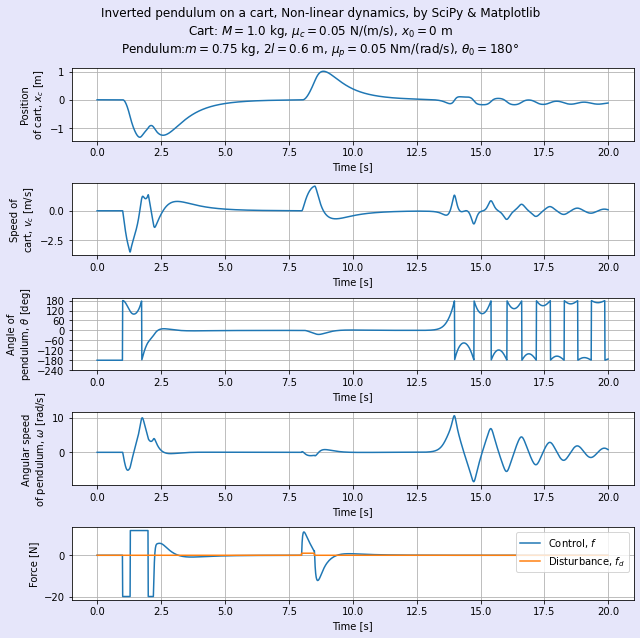

In [11]:
# Time-domain plots
plt.rcParams["font.size"] = 10
fig, ax = plt.subplots(5, 1, figsize = (9, 9))
fig.patch.set_facecolor('lavender')
#fig.suptitle(f'Inverted pendulum on a cart, $M = {M}$ kg, $m = {m}$ kg, $2l = {2 * l}$ m, $\mu_c = {mu_c}$ N/(m/s), $\mu_p = {mu_p}$ Nm/(rad/s)')
fig.suptitle(f'Inverted pendulum on a cart, Non-linear dynamics, by SciPy & Matplotlib\nCart: $M = {M}$ kg, $\mu_c = {mu_c}$ N/(m/s), $x_0 = {x_c0}$ m\nPendulum:$m = {m}$ kg, $2l = {2 * l}$ m, $\mu_p = {mu_p}$ Nm/(rad/s), $\\theta_0 = {theta_0}\degree$')

# Plot position of cart
ax[0].plot(t, x_c)
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Position\nof cart, $x_{c}$ [m]')
ax[0].grid()

# Plot speed of cart
ax[1].plot(t, v_c)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Speed of\ncart, $v_{c}$ [m/s]')
ax[1].grid()

# Plot angle of pendulum
ax[2].plot(t, np.degrees(theta))
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('Angle of\npendulum, $\\theta$ [deg]')
ax[2].set_yticks(range(-240, 240, 60))
ax[2].grid()

# Plot angular speed of pendulum
ax[3].plot(t, omega)
ax[3].set_xlabel('Time [s]')
ax[3].set_ylabel('Angular speed\nof pendulum, $\\omega$ [rad/s]')
ax[3].grid()

# Control force
ax[4].plot(t, np.array([f_cont, f_disturb]).T, label = ['Control, $f$', 'Disturbance, $f_{d}$'])
ax[4].set_xlabel('Time [s]')
ax[4].set_ylabel('Force [N]')
ax[4].legend(loc = 'upper right')
ax[4].grid()

fig.tight_layout()

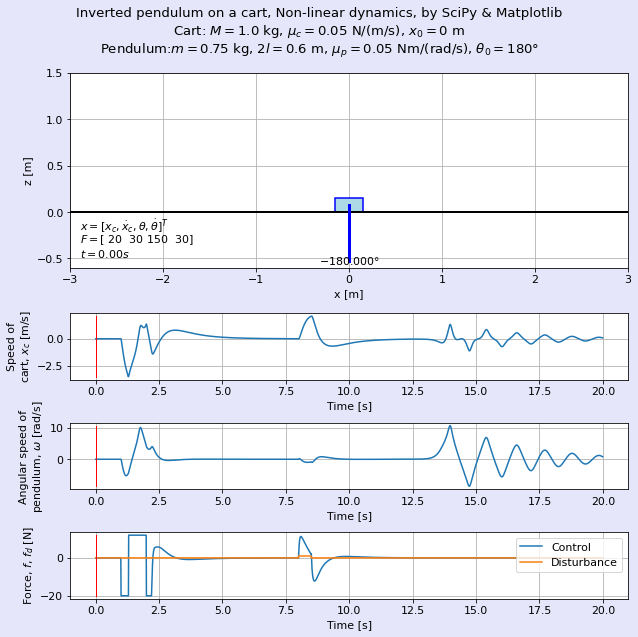

In [12]:
# Animate
# Animation setting
w_cart = 0.30          # Width of cart, m
h_cart = 0.15          # Height of cart, m
K_tscale = 3           # Size of theatre

# Plot theatre
plt.rcParams["font.size"] = 11
fig, ax = plt.subplots(4, 1, figsize = (9, 9), gridspec_kw={'height_ratios': [3, 1, 1, 1]})
fig.patch.set_facecolor('lavender')
ax[0].set_aspect('equal')
fig.suptitle(f'Inverted pendulum on a cart, Non-linear dynamics, by SciPy & Matplotlib\nCart: $M = {M}$ kg, $\mu_c = {mu_c}$ N/(m/s), $x_0 = {x_c0}$ m\nPendulum:$m = {m}$ kg, $2l = {2 * l}$ m, $\mu_p = {mu_p}$ Nm/(rad/s), $\\theta_0 = {theta_0}\degree$')

# Set axis for animation
ax[0].set_xlim(-K_tscale, K_tscale)
ax[0].set_xlabel('x [m]')
ax[0].set_ylim(-K_tscale / 5, K_tscale / 2)
ax[0].set_ylabel('z [m]')
ax[0].grid()
ax[0].set_axisbelow(True)

# Show state feedback gain
ax[0].text(-K_tscale + 0.1, -K_tscale / 20, '$x = [x_{c}, \\dot{x}_{c}, \\theta, \\dot{\\theta}]^T$', va = 'center')
ax[0].text(-K_tscale + 0.1, -2 * K_tscale / 20, f'$F = ${F}', va = 'center')

# Show time
text_time = ax[0].text(-K_tscale + 0.1, -3 * K_tscale / 20, f'$t = {t[0]:.2f} s$', va = 'center')

# Draw floor
ax[0].plot([-10, 10], [0, 0], lw = 2, color = 'black')

# Draw cart
cart = patches.Rectangle(xy = (x_c[0] - w_cart / 2, 0), width = w_cart, height = h_cart, lw = 1.5, ec = 'blue', fc = 'lightblue')
ax[0].add_patch(cart)

# Draw pendulum
pendulum, = ax[0].plot([x_c[0], x_c[0] + 2 * l * np.sin(theta[0])],[h_cart / 2, h_cart / 2 + 2 * l * np.cos(theta[0])], \
    lw = 3, color = 'blue')

# Show angle of pendulum over it
text_angle = ax[0].text(x_c[0] + 2 * l * 1.1 * np.sin(theta[0]), h_cart / 2 + 2 * l * 1.1 * np.cos(theta[0]), \
    f'${np.degrees(theta[0]):.3f}\degree$', ha = 'center', va = 'bottom')

# Show control and disturbance forces as arrows
K_fscale = K_tscale / 40
arrow_cont = ax[0].arrow(x_c[0] - w_cart / 2 * np.sign(f_cont[0]) - K_fscale * f_cont[0], \
    h_cart / 2, K_fscale * f_cont[0], 0, length_includes_head = True, width = K_tscale * 0.01, color = 'blue', alpha = 0.6)

arrow_disturb = ax[0].arrow(x_c[0] + 2 * l * np.sin(theta[0]) - K_fscale * f_disturb[0], h_cart / 2 + 2 * l * np.cos(theta[0]), \
    K_fscale * f_disturb[0], 0, length_includes_head = True, width = K_tscale * 0.01, color = 'orange', alpha = 0.6)

# Time-domain plots
# Plot speed of cart
ax[1].plot(t, v_c)
line_time_v_c, = ax[1].plot([t[0], t[0]], [np.min(v_c), np.max(v_c)], lw = 1, c = 'red') 
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Speed of\ncart, $x_{c}$ [m/s]')
ax[1].grid()

# Plot angular speed of pendulum
ax[2].plot(t, omega)
line_time_omega, = ax[2].plot([t[0], t[0]], [np.min(omega), np.max(omega)], lw = 1, c = 'red') 
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('Angular speed of\npendulum, $\\omega$ [rad/s]')
ax[2].grid()

# Plot forces
ax[3].plot(t, np.array([f_cont, f_disturb]).T, label = ['Control', 'Disturbance'])
line_time_force, = ax[3].plot([t[0], t[0]], [np.min(f_cont), np.max(f_cont)], lw = 1, c = 'red') 
ax[3].set_xlabel('Time [s]')
ax[3].set_ylabel('Force, $f$, $f_{d}$ [N]')
ax[3].legend(loc = 'upper right')
ax[3].grid()

fig.tight_layout()

In [13]:
# Function to update frame
def animate(i):
    # Update cart position
    cart.set_x(x_c[i] - w_cart / 2)
    
    # Update pendulum attitude
    pendulum.set_data([x_c[i], x_c[i] + 2 * l * np.sin(theta[i])],[h_cart / 2, h_cart / 2 + 2 * l * np.cos(theta[i])])
    
    # Update pendulum angle text
    text_angle.set_position((x_c[i] + 2 * l * 1.1 * np.sin(theta[i]), h_cart / 2 + 2 * l * 1.1 * np.cos(theta[i])))
    text_angle.set_text(f'${np.degrees(theta[i]):.3f}\degree$')
    
    # Update time text
    text_time.set_text(f'$t = {t[i]:.2f}$ s')
    
    # Update force arrow
    kwargs = {'x': x_c[i] - w_cart / 2 * np.sign(f_cont[i]) - K_fscale * f_cont[i], 'dx': K_fscale * f_cont[i]}
    arrow_cont.set_data(**kwargs)
    kwargs = {'x': x_c[i] + 2 * l * np.sin(theta[i]) - K_fscale * f_disturb[i], 'y': h_cart / 2 + 2 * l * np.cos(theta[i]), 'dx': K_fscale * f_disturb[i]}
    arrow_disturb.set_data(**kwargs)
    
    # Update time lines
    line_time_v_c.set_data([t[i], t[i]], [np.min(v_c), np.max(v_c)])
    line_time_omega.set_data([t[i], t[i]], [np.min(omega), np.max(omega)])
    line_time_force.set_data([t[i], t[i]], [np.min(f_cont), np.max(f_cont)])
    
    return (cart, pendulum, text_angle, text_time, line_time_v_c, line_time_omega, line_time_force)

In [14]:
# Create animation
ani = animation.FuncAnimation(fig, animate, \
    frames = np.arange(0, len(t), 5), interval = dt * 5 * 1000, blit = True)

# Show animation
HTML(ani.to_html5_video())

In [15]:
# Save animation GIF
ani.save('inverted-pendulum.gif')

The generated animation GIF is shown below.
<figure><img src="inverted-pendulum.gif"><figcaption>Fig. 2 Generated animation GIF.</figcaption></figure>